In [1]:
SAVE = False

In [2]:
import pandas as pd
import numpy as np
from IPython import get_ipython
from IPython.core.display_functions import display

import sys, os ## append parent path to dir to allow import
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)
from util import get_sentence_pairs_similarity, wrangle_df_icu, anti_join_df,test_nel,get_multiple_nel,link_kg_concepts_slim
from util import *
from ukb_target_pipe  import * # make_target_df,model_features#*
import string
rem = string.punctuation
punct_pattern = r"[{}]".format(rem)
from configs import * #config_gall

from os import listdir
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [3]:
# from configs import *
all_configs = [
    config_gall,  config_gout,
    config_celiac,config_spine,
    config_oesophagus, config_heart, config_eye_occ,config_depression
              ] 

## Num Feats per pipeline step
* Count of features per step of the pipeline - for all or just 1?


* KG filter :
    *  semantic similarity, top1 hit, and :
    *   `df_hits.query("(KG_Hits==0) & (feature_level_min_kg_hits<=3)").drop_duplicates()`

In [5]:
c["FEATURES_REPORT_PATH"]

'depression_report.csv'

In [10]:
llm_ranked_csvs

['oesophagus__reranked_gpt4.csv',
 'spine__reranked_gpt4.csv',
 'heart__reranked_gpt4.csv',
 'depression__reranked_gpt4.csv',
 'gallstone__reranked_gpt4.csv',
 'eye_occ__reranked_gpt4.csv',
 'gout__reranked_gpt4.csv',
 'celiac__reranked_gpt4.csv']

In [20]:
li = []
report_path="./Outputs/llm_reranked/" # "./Outputs/llm_reranked/subset/"
llm_ranked_csvs = find_csv_filenames(report_path, suffix=".csv" )
# for c in all_configs:
for c in llm_ranked_csvs:
    # FEATURES_REPORT_PATH
    # df = pd.read_csv(c["CANDIDATE_NOVEL_CUIS_FILEPATH"], index_col=None, header=0)
    df = pd.read_csv(report_path+c)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
display(frame.query("answer==True")["p_val"].describe().round(4))
# display(frame.query("p_val<0.23")["p_val"].describe().round(4))
# display(frame.loc[frame["Interesting?"]==True]["p_val"].describe().round(4))
frame.columns

count    430.0000
mean       0.1229
std        0.2364
min        0.0000
25%        0.0000
50%        0.0010
75%        0.0990
max        0.9930
Name: p_val, dtype: float64

Index(['feature', 'novel_cot', 'plausible_cot', 'novel', 'plausible',
       'utility', 'shortest_path_length', 'corr', 'raw_name', 'p_val',
       'feature_importance', 'MutualInfoTarget', 'F.Split-Lift (y==1)',
       'F.Split-Feature Split', 'target', 'step_by_step_explanation', 'answer',
       'numeric_score', 'error', 'boring_pred', 'boring_cot'],
      dtype='object')

In [4]:
%%time
res_dict_list = []
for c in all_configs:
    print("-----"*11,c["TARGET_NAME"])
    res_dict = {}
    res_dict["Target Disease"] = c["TARGET_NAME"]

    try:
        df_raw = pd.read_parquet(c["OUTPUT_RES_PREFIX"]+"_raw_df.parquet") # not present for all 
    except:
        print("Making raw df")
        print("Running pipeline for:", c["TARGET_NAME"])
        df_raw = make_target_df(TARGET_CODES_LIST=c["TARGET_CODES_LIST"])
        print("-------"*5, "\nTarget extracted\n", "-------"*8)
        print(df_raw.shape)
        df_raw.to_parquet(c["OUTPUT_RES_PREFIX"]+"_raw_df.parquet",index=False)
    
    res_dict["Disease Counts"] = df_raw["y"].sum()
    res_dict["Disease Prevalence (%)"] = round(100*df_raw["y"].mean(),2)
    
    df_util = pd.read_csv(c["FEATURES_REPORT_PATH"])#.query("(p_val<0.2)|(feature_importance>=0.0001)") # 2 rows diff
    print(df_util.shape,"raw df_util")
    # print(df_util.query("(p_val<0.2)|(feature_importance>=0.0001)").shape)
    df_util = df_util.loc[(df_util["feature_importance"] >= 0.001) | (df_util["p_val"] < 0.2) | (
            df_util["MutualInfoTarget"] > 0.001)]
    print(df_util.shape,"util with feature filt like paper") ## ~ 3 rows difference = it is consistant with paper

    res_dict["# Features After Utility Filtering"] = df_util["raw_name"].nunique()#.shape[0]

    df_kg = pd.read_csv(c["CANDIDATE_NOVEL_CUIS_FILEPATH"])
    print(df_kg.shape[0],"kg pre checking by util filt")
    df_kg = df_kg.loc[df_kg["raw_name"].isin(df_util["raw_name"])]
    print(df_kg.shape[0],"kg after util filt")
    # display(df_kg)
    res_dict["# Features After Knowledge Graph"] = df_kg["raw_name"].nunique()#.shape[0]

### text/pubmed search results :
    ## there's results and there's top results... 
    df_textSearch_all = pd.read_csv(f"{c.get('OUTPUT_RES_PREFIX', '')}{c.get('full_results_filename', 'candidates_search_results.csv')}")
    print("text search all")
    print(df_textSearch_all.shape)
    print(df_textSearch_all.raw_name.nunique())
    print("text search top/promising (used)")
    df_textSearch_top = pd.read_csv(f"{c.get('OUTPUT_RES_PREFIX', '')}{c.get('filtered_results_filename', 'review_interesting_candidates_results.csv')}")
    print(df_textSearch_top.shape)
    print(df_textSearch_top.raw_name.nunique())
    df_textSearch_top = df_textSearch_top.loc[df_textSearch_top["raw_name"].isin(df_util["raw_name"])]
    print(df_textSearch_top.raw_name.nunique(),"text top + util filt")
    res_dict["# Features After Literature Search"] = df_textSearch_top['raw_name'].nunique()

    df_lm_ranked = pd.read_csv(os.path.join("./Outputs/llm_reranked",c['OUTPUT_RES_PREFIX']+"_reranked_gpt4.csv"))
    print(df_lm_ranked.shape[0],"# final-final LM candidates")
    # df_lm_ranked = df_lm_ranked.query("((novel>0) & (plausible>0))|(answer)")#.#query("(novel>0)|(answer)")
    df_lm_ranked = df_lm_ranked.query("answer")
    print(df_lm_ranked.shape[0],"# LM Picks")
    res_dict["# Features selected by LLM"] = df_lm_ranked.shape[0]
    print("----"*6, "\nappended\n", "----"*5)

    res_dict_list.append(res_dict)

df_pipeline_stats = pd.DataFrame(res_dict_list)

------------------------------------------------------- GALLSTONES, Cholelithiasis
(1447, 11) raw df_util
(1447, 11) util with feature filt like paper
1381 kg pre checking by util filt
1381 kg after util filt
text search all
(964, 29)
347
text search top/promising (used)
(157, 17)
157
157 text top + util filt
132 # final-final LM candidates
49 # LM Picks
------------------------ 
appended
 --------------------
------------------------------------------------------- Gout
(1707, 11) raw df_util
(1707, 11) util with feature filt like paper
1677 kg pre checking by util filt
1677 kg after util filt
text search all
(1078, 29)
405
text search top/promising (used)
(148, 17)
148
148 text top + util filt
129 # final-final LM candidates
62 # LM Picks
------------------------ 
appended
 --------------------
------------------------------------------------------- Coeliac disease
(953, 11) raw df_util
(953, 11) util with feature filt like paper
1059 kg pre checking by util filt
1059 kg after util fi

In [5]:
df_pipeline_stats.columns

Index(['Target Disease', 'Disease Counts', 'Disease Prevalence (%)',
       '# Features After Utility Filtering',
       '# Features After Knowledge Graph',
       '# Features After Literature Search', '# Features selected by LLM'],
      dtype='object')

In [6]:
display(df_pipeline_stats)
if SAVE:
    df_pipeline_stats.to_csv("./Outputs/Figures/Table-PipelineStats.csv",index=False)

,Target Disease,Disease Counts,Disease Prevalence (%),# Features After Utility Filtering,# Features After Knowledge Graph,# Features After Literature Search,# Features selected by LLM
0,"GALLSTONES, Cholelithiasis",19658,5.07,1447,697,157,49
1,Gout,9159,2.36,1707,812,148,62
2,Coeliac disease,2653,0.68,953,487,134,61
3,Spine degeneration,24867,6.42,2430,1187,136,72
4,Esophageal cancer,1518,0.39,611,408,152,59
5,Heart attack,3638,0.94,1008,520,102,43
6,Retinal Vein Occlusion,1246,0.32,558,402,163,59
7,Depression,25880,6.68,2537,1036,77,25


In [7]:
df_raw

,eid,YOB,Sex,instance0_date,y,past disease history - Age_at_diagnosis,past disease history - Z-score-Age_at_diagnosis,had_disease_past,age,cutoff_date,...,Date of vascular dementia report,Behavioural and miscellaneous addictions,Ever addicted to any substance or behaviour,Ongoing addiction or dependence on illicit or recreational drugs,Ever addicted to a behaviour or miscellanous,Ever addicted to illicit or recreational drugs,Date elapsed of all cause dementia report,Date elapsed of alzheimer's disease report,Date elapsed of vascular dementia report,age_X_sex
0,4107889,1957,0,2008-10-06,0,NaN,NaN,False,56,2013-10-22,...,NaT,None,None,None,None,None,NaN,NaN,NaN,-1
1,3650476,1941,1,2009-08-04,0,NaN,NaN,False,72,2013-01-30,...,NaT,None,None,None,None,None,NaN,NaN,NaN,1
2,3612392,1956,0,2009-03-18,0,NaN,NaN,False,61,2017-10-10,...,NaT,None,No,None,None,None,NaN,NaN,NaN,-1
3,1452516,1967,0,2009-12-11,0,NaN,NaN,False,48,2015-11-03,...,NaT,None,None,None,None,None,NaN,NaN,NaN,-1
4,5938121,1964,0,2008-10-22,0,NaN,NaN,False,46,2010-09-25,...,NaT,None,None,None,None,None,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387461,1516071,1941,0,2008-08-14,0,NaN,NaN,False,74,2015-12-23,...,NaT,None,None,None,None,None,NaN,NaN,NaN,-1
387462,1898210,1956,0,2008-11-18,0,NaN,NaN,False,58,2014-08-11,...,NaT,None,No,None,None,None,NaN,NaN,NaN,-1
387463,1287714,1945,0,2008-12-06,0,NaN,NaN,False,65,2010-10-06,...,NaT,None,None,None,None,None,NaN,NaN,NaN,-1
387464,5324510,1947,0,2010-06-25,0,NaN,NaN,False,63,2010-10-01,...,NaT,None,None,None,None,None,NaN,NaN,NaN,-1


In [7]:
# ## ~ feature after extract in ful ldata before util
# df = df_raw
# # if config.get("do_IPW", True):
# df = ipw_downsampling(df, K_IPW_RATIO=config.get("K_IPW_RATIO", 11))
# print(df.shape, "IPW downsampled")
 
# full_feat = model_features(df=df, FAST=False,    K_diag_thresh_value=200,SAVE_OUTPUT=False,  do_mi_fs_filt=False,) ## Fitted with 3721 feat 

In [8]:
for config in all_configs:
    print("-----"*11,config["TARGET_NAME"])
    ## result_df
    print(pd.read_csv(f"{config.get('OUTPUT_RES_PREFIX', '')}{config.get('full_results_filename', 'candidates_search_results.csv')}").shape)
    # pick_result_df:: 
    pick_result_df = pd.read_csv(
        f"{config.get('OUTPUT_RES_PREFIX', '')}{config.get('filtered_results_filename', 'review_interesting_candidates_results.csv')}")
    print(pick_result_df.shape[0])

------------------------------------------------------- GALLSTONES, Cholelithiasis
(964, 29)
157
------------------------------------------------------- Gout
(1078, 29)
148
------------------------------------------------------- Coeliac disease
(769, 29)
134
------------------------------------------------------- Spine degeneration
(1504, 29)
136
------------------------------------------------------- Esophageal cancer
(812, 29)
152
------------------------------------------------------- Heart attack
(715, 29)
102
------------------------------------------------------- Retinal Vein Occlusion
(877, 29)
163
------------------------------------------------------- Depression
(701, 29)
77


In [9]:
# C:\Users\ddofe\OneDrive - Medtronic PLC\Documents\research\InterestingFeats\code\code\Outputs\llm_reranked
path_to_dir = "./Outputs/llm_reranked"
for path in find_csv_filenames(path_to_dir):
    print(path.split("_")[0],pd.read_csv(os.path.join(path_to_dir,path)).shape[0])

oesophagus 138
spine 122
heart 86
depression 59
gallstone 132
eye 133
gout 129
celiac 112


## Baseline of Feature importance vs our method and % human annotted picks captured:
## establish baseline of top features by shap
* compare to model picks
* compare to human picks.
* note we only have some targets supported

#### Overlap of top 40 features by shap and novel candidates ? 
* get df_util and sort then check overlap (with llm filt?)

#### \subsubsection{Utility/SHAP Baseline Comparison}

In [10]:
## outputs of : http://localhost:8888/notebooks/analyze_annotations_agreement.ipynb
# ## concatenated annots (human+model) of, real, features, across targets
df_real = pd.read_csv("./Outputs/analyses/real_compare.csv").dropna(axis=0)
df_real["int_pick"] = (df_real["interesting_human"]>2).astype(int)
df_real = df_real.sort_values(["target","interesting_model","confidence_model","feature_importance"],ascending=False)
print("@Top 15 - model picked Interesting cases")
df_real.groupby(["target"]).head(15).groupby(["target"])[["int_pick"]].agg(["mean","sum"]).round(2)

@Top 15 - model picked Interesting cases


int_pick    
                                                       mean sum
target                                                         
(Cholelithiasis) OR (Gallstone) OR (Gallbladder...     0.40   6
oesophagus cancer                                      0.53   8

In [11]:
print("@Top 5 - model picked Interesting cases")
df_real.groupby(["target"]).head(5).groupby(["target"])[["int_pick"]].agg(["mean","sum"])

@Top 5 - model picked Interesting cases


int_pick    
                                                       mean sum
target                                                         
(Cholelithiasis) OR (Gallstone) OR (Gallbladder...      0.2   1
oesophagus cancer                                       0.6   3

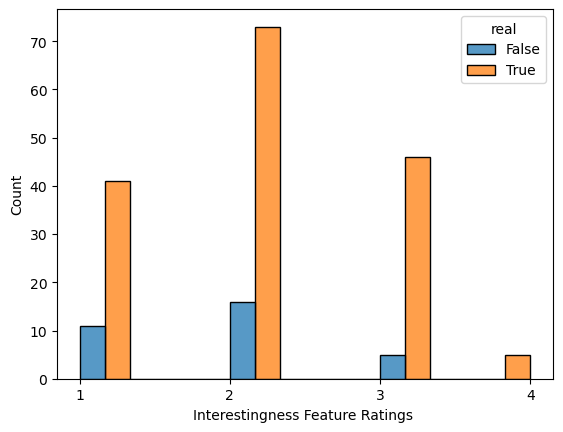

In [12]:
df = pd.concat([pd.read_csv("./Outputs/analyses/real_compare.csv"),pd.read_csv("./Outputs/analyses/fake_compare.csv")]).dropna(subset=["interesting_human"])
# df.hist(column=["interesting_human"], by=["real"],sharex=True,sharey=True)

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(x="interesting_human", hue="real", data=df, multiple="dodge")
plt.xticks([1, 2, 3, 4])  # Set the tick positions to integers only
plt.xlabel("Interestingness Feature Ratings ")  # Set the x-axis label
plt.ylabel("Count")  # Optionally set the y-axis label for clarity
# plt.legend(title="Group (Real vs. Fake Distractors)")  # Update legend title for clarity
plt.show()

In [17]:
df_annotated

,Feature_Name,explanation,correlation,Target,Comments,Novel?,Plausible-Makes sense?,Utility?,Interesting?
6,(BC) breast cancer genetic risk,The feature 'BC breast cancer genetic risk' be...,positive,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,may relate through pregnancies \ preventive re...,4.0,3.0,2.0,3.0
8,Cholesterol in Medium HDL,The feature 'Cholesterol in Medium HDL' is eva...,negative,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,maybe a protective factor for hypercholesterol...,3.0,3.0,2.0,3.0
11,(HT) hypertension genetic risk,1. **Novelty:** The association between hypert...,positive,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,-,3.0,3.0,2.0,3.0
13,(HBA1C_DF) glycated haemoglobin genetic risk,The feature 'HBA1C DF glycated haemoglobin gen...,positive,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,metabolic syndrome?,3.0,3.0,2.0,3.0
14,"Medication for cholesterol, blood pressure, di...",1. **Novelty:** The association between blood ...,positive,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,many known connections the best are fibrates (...,1.0,4.0,3.0,3.0
21,A09.9 - Gastroenteritis and colitis of unspeci...,1. **Novelty:** The association between 'A09.9...,positive,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,many known connections to IBD,3.0,3.0,2.0,3.0
23,Vitamin D,The feature 'Vitamin D' in relation to gallbla...,negative,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,see - https://pubmed.ncbi.nlm.nih.gov/27696253/,3.0,2.0,3.0,3.0
24,Sleep - Overall average,1. **Novelty:** The relationship between sleep...,positive,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,-,3.0,3.0,3.0,3.0
25,(AD) alzheimer's disease genetic risk,The feature 'AD Alzheimer's disease genetic ri...,negative,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,hard to judge,4.0,2.0,2.0,3.0
26,(SCZ) schizophrenia genetic risk,The feature 'SCZ schizophrenia genetic risk' i...,negative,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,hard to judge,4.0,2.0,2.0,3.0


In [15]:
print("GALLSTONES")
df_llm = pd.read_csv("./Outputs/llm_reranked/gallstone__reranked_gpt4.csv")
print(df_llm.shape[0])
df_llm = df_llm.query("(novel>0)|(answer)")
print(df_llm.shape[0])
df_llm = df_llm.query("answer")
print(df_llm.shape[0])

df_annotated = pd.read_excel("./Outputs/annotaters_results/Pasi_gallstone_candidates.xlsx")
print(df_annotated.shape[0])
df_annotated = df_annotated.loc[df_annotated["Interesting?"]>2]
print(df_annotated.shape[0])

NUM_LLM_CANDS = min(df_llm.shape[0],40)
c = config_gall

df_util = pd.read_csv(c["FEATURES_REPORT_PATH"])
top_shapFeats = set(df_util.sort_values("feature_importance",ascending=False).drop_duplicates().head(NUM_LLM_CANDS)["raw_name"].unique())
## pre-llm feat overlap:
print("Top 15 Shap Feat\n",df_util.sort_values("feature_importance",ascending=False).drop_duplicates().head(15)["raw_name"].unique())
print("pre-llm feat overlap")
preLLM_overlap_feats = set(df_textSearch_top["raw_name"].unique()).intersection(top_shapFeats)
print(len(preLLM_overlap_feats))
print(preLLM_overlap_feats)

print("# human top picks",len(df_annotated["Feature_Name"].unique()))
##  Human  overlap with top shap:
print("\nHuman  overlap with top shap:")
print(len(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats)))
print(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats))
print(len(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats))/15)
# ##  Human  overlap with model candidates:
# print("\nHuman  overlap with model candidates:")
# print(set(df_annotated["Feature_Name"].unique()).intersection(set(df_llm["raw_name"])))


GALLSTONES
132
108
49
51
18
Top 15 Shap Feat
 ['Arm fat percentage (left)' 'HDL cholesterol Blood biochemistry'
 'Alanine aminotransferase' 'Triglycerides Blood biochemistry'
 'Alcohol intake frequency._Daily or almost daily' 'Abdominal pain'
 'Direct bilirubin' 'missing_Abdominal pain'
 'Alcohol intake frequency._Three or four times a week'
 'missing_Cholelithiasis with other cholecystitis'
 'Mineral and other dietary supplements_None of the above'
 'Leg fat-free mass (right)'
 'Long-standing illness, disability or infirmity_Yes'
 'Weight change compared with 1 year ago_Yes - lost weight'
 'Major dietary changes in the last 5 years_No']
pre-llm feat overlap
8
{'Triglycerides Blood biochemistry', 'HDL cholesterol Blood biochemistry', 'Apolipoprotein A Blood biochemistry', '(LDL_SF) low density lipoprotein cholesterol genetic risk', 'Mental health conditions ever diagnosed by a professional__of', 'Alanine aminotransferase', 'Weight change compared with 1 year ago_Yes - lost weight', 'Di

In [16]:
df_util.sort_values("feature_importance",ascending=False).drop_duplicates().head(15)

,name,feature_importance,p_val,corr,support,MutualInfoTarget,raw_name,F.Split-Lift (y==1),F.Split-Support,F.Split-Target % Covered,F.Split-Feature Split
0,Arm fat percentage (left),0.0814,0.0000,0.043,196580,0.0012,Arm fat percentage (left),2.05,288,0.30,Arm fat percentage (left) >= 2.90
1,HDL cholesterol Blood biochemistry,0.0636,0.0000,-0.039,196580,0.0018,HDL cholesterol Blood biochemistry,1.80,345,0.32,HDL cholesterol Blood biochemistry < -2.20
2,Alanine aminotransferase,0.0430,0.0000,0.019,196580,0.0014,Alanine aminotransferase,1.45,1418,1.04,4.00 <= Alanine aminotransferase < 11.00
3,Triglycerides Blood biochemistry,0.0412,0.0000,0.031,196580,0.0000,Triglycerides Blood biochemistry,1.73,214,0.19,0.00 <= Triglycerides Blood biochemistry < 0.00
4,Alcohol intake frequency._Daily or almost daily,0.0406,0.0000,-0.037,196580,0.0039,Alcohol intake frequency._Daily or almost daily,1.05,159539,85.49,Alcohol intake frequency._Daily or almost dail...
5,Abdominal pain,0.0377,0.0000,0.021,196580,0.0017,Abdominal pain,2.30,814,0.95,Abdominal pain >= 4.30
6,Direct bilirubin,0.0374,0.0000,0.010,196580,0.0019,Direct bilirubin,2.83,113,0.16,6.60 <= Direct bilirubin < 7.50
7,_Abdominal pain,0.0369,0.0000,-0.055,196580,0.0108,missing_Abdominal pain,1.44,23407,17.20,missing_Abdominal pain < -1.20
8,Alcohol intake frequency._Three or four times ...,0.0274,0.0000,-0.027,196580,0.0053,Alcohol intake frequency._Three or four times ...,1.04,154910,82.05,Alcohol intake frequency._Three or four times ...
9,_Cholelithiasis with other cholecystitis,0.0263,0.0000,0.016,196580,0.0032,missing_Cholelithiasis with other cholecystitis,1.00,194814,99.55,missing_Cholelithiasis with other cholecystiti...


* check that correct - we have 2 oesophagus annotators!!

In [13]:
print("Oesophagus cancer")
## check that correct - we have 2 oesophagus annotators!!

df_llm = pd.read_csv("./Outputs/llm_reranked/oesophagus__reranked_gpt4.csv")
print(df_llm.shape[0])
df_llm = df_llm.query("(novel>0)|(answer)")
print(df_llm.shape[0])
df_llm = df_llm.query("answer")
print(df_llm.shape[0])
## one annotator:
df_annotated = pd.read_excel("./Outputs/annotaters_results/Palsi-FILL-oesophagus_candidates.xlsx")
print(df_annotated.shape[0])
df_annotated = df_annotated.loc[df_annotated["Interesting?"]>2]
print(df_annotated.shape[0])

NUM_LLM_CANDS = min(df_llm.shape[0],40)

c = config_oesophagus
df_util = pd.read_csv(c["FEATURES_REPORT_PATH"])
top_shapFeats = set(df_util.sort_values("feature_importance",ascending=False).drop_duplicates().head(NUM_LLM_CANDS)["raw_name"].unique())
print("Top Shap Feat\n",df_util.sort_values("feature_importance",ascending=False).drop_duplicates().head(15)["raw_name"].unique())

## pre-llm feat overlap:
print("pre-llm feat overlap")
preLLM_overlap_feats = set(df_textSearch_top["raw_name"].unique()).intersection(top_shapFeats)
print(len(preLLM_overlap_feats))
print(preLLM_overlap_feats)

print("# human top picks",len(df_annotated["Feature_Name"].unique()))
##  Human  overlap with top shap:
print("\nHuman  overlap with top shap:")
print(len(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats)))
print(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats))
print(len(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats))/15)
# ##  Human  overlap with model candidates:
# print("\nHuman  overlap with model candidates:")
# print(set(df_annotated["Feature_Name"].unique()).intersection(set(df_llm["raw_name"])))


Oesophagus cancer
138
133
59
52
21
Top Shap Feat
 ['Mental health conditions ever diagnosed by a professional__of'
 'Mental health conditions ever diagnosed by a professional__group'
 'Mental health conditions ever diagnosed by a professional__none of'
 'Mental health conditions ever diagnosed by a professional__of group'
 'had_disease_past' 'missing_Ulcer of esophagus' 'Urea' 'Coffee intake'
 'Total bilirubin' '3-Hydroxybutyrate' 'Genetic ethnic grouping_None'
 'Tea intake' '(non-UK origin) Country of Birth__none' 'SHBG'
 'Method of diagnosis when first had COVID-19_None']
pre-llm feat overlap
7
{'Genetic ethnic grouping_None', '(PSO) psoriasis genetic risk', 'Skin colour_Brown', '(MEL) melanoma genetic risk', 'Mental health conditions ever diagnosed by a professional__of', 'Mental health conditions ever diagnosed by a professional__of group', '(United Kingdom) Year immigrated to UK_None'}
# human top picks 21

Human  overlap with top shap:
6
{'Acetoacetate', 'Vitamin D', 'Acetone', '

In [34]:
print("Gout")
df_llm = pd.read_csv("./Outputs/llm_reranked/gout__reranked_gpt4.csv")
print(df_llm.shape[0])
df_llm = df_llm.query("answer")
print(df_llm.shape[0])

df_annotated = pd.read_csv("./Outputs/annotaters_results/gout_candidates-TALI.csv")
print(df_annotated.shape[0])
df_annotated = df_annotated.loc[df_annotated["Interesting?"]>2]
print(df_annotated.shape[0])

NUM_LLM_CANDS = min(df_llm.shape[0],40)
c = config_gout
df_util = pd.read_csv(c["FEATURES_REPORT_PATH"])
top_shapFeats = set(df_util.sort_values("feature_importance",ascending=False).drop_duplicates().head(NUM_LLM_CANDS)["raw_name"].unique())
## pre-llm feat overlap:
print("Top 10 Shap Feat\n",df_util.sort_values("feature_importance",ascending=False).drop_duplicates().head(15)["raw_name"].unique())
print("pre-llm feat overlap")
preLLM_overlap_feats = set(df_textSearch_top["raw_name"].unique()).intersection(top_shapFeats)
print(len(preLLM_overlap_feats))
print(preLLM_overlap_feats)

print("# human top picks",len(df_annotated["Feature_Name"].unique()))
##  Human  overlap with top shap:
print("\nHuman  overlap with top shap:")
print(len(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats)))
print(set(df_annotated["Feature_Name"].unique()).intersection(top_shapFeats))


Gout
129
62
60
10
Top 10 Shap Feat
 ['Urate' 'Treatment/medication code | Array 0__allopurinol'
 'Home area population density - urban or rural_Scotland - Large Urban Area'
 '(BMI) Body mass index (p21001)' 'Weight (p21002)'
 'Non-cancer illness code, self-reported | Array 1__gout'
 'missing_Z51.5 - Palliative care'
 'Number of treatments/medications taken'
 'Alcohol intake frequency._Daily or almost daily'
 'Vascular/heart problems diagnosed by doctor_None of the above' 'age'
 'Water intake' 'Sex' 'Number of self-reported non-cancer illnesses'
 'Treatment/medication code | Array 0__none']
pre-llm feat overlap
8
{'Urate', 'Microalbumin in urine', 'Home area population density - urban or rural_Scotland - Large Urban Area', 'Weight (p21002)', 'Apolipoprotein B Blood biochemistry', 'Long-standing illness, disability or infirmity_No', 'Alanine aminotransferase', 'Home area population density - urban or rural_Scotland - Other Urban Area'}
# human top picks 10

Human  overlap with top shap:


#### Recall_link_known_semmed_cuis.ipynb
* KG coverage/overlap and temporal cutoff results

In [15]:
df_kg_time = pd.read_csv("./Outputs/Figures/future_recall_coverage_report.csv").drop_duplicates()
display(df_kg_time)

,target,num_unique_input_features,num_features_without_KG_link,num_features_with_KG_link,percent_features_with_KG_link,percent_features_within_1_hop,num_features_within_1_hop,percent_features_within_2_hop,num_features_within_2_hop,num_cases_post_cutoff,percent_cases_after_cutoff_year,list_of_target_cuis,num_unique_target_cuis,df_kg_sep_size,frac_postCutoffYear_dist1,sum_postCutoffYear_dist1,count_before_CutoffYear_dist1
0,"GALLSTONES, Cholelithiasis",854,152,702,14.53,14.53,102,97.58,685,19,0.19,"['C0947622', 'C0008325', 'C0242216', 'C0008311...",5,1206,0.19,19,83
1,Gout,994,149,845,18.70,18.70,158,97.16,821,38,0.24,['C0018099'],1,935,0.24,38,120
2,Coeliac disease,639,134,505,21.19,21.19,107,97.43,492,14,0.13,"['C0007570', 'C5139492']",2,1613,0.13,14,93
3,Spine degeneration,1247,159,1088,17.28,17.28,188,97.89,1065,37,0.20,"['C0158266', 'C0024031', 'C0850918', 'C0038019...",7,1695,0.20,37,151
4,Esophageal cancer,482,72,410,7.80,7.80,32,97.80,401,10,0.31,"['C0014859', 'C0152018', 'C0546837']",3,1367,0.31,10,22
5,Heart attack,704,159,545,22.20,22.20,121,98.72,538,7,0.06,"['C0027051', 'C0155668']",2,4502,0.06,7,114
6,Retinal Vein Occlusion,428,29,399,2.26,2.26,9,96.49,385,0,0.00,['C0035327'],1,57,0.00,0,9
7,Depression,1397,321,1076,18.59,18.59,200,98.70,1062,32,0.16,"['C0011570', 'C0011581', 'C0344315']",3,6547,0.16,32,168


In [16]:
df_kg_time.columns

Index(['target', 'num_unique_input_features', 'num_features_without_KG_link',
       'num_features_with_KG_link', 'percent_features_with_KG_link',
       'percent_features_within_1_hop', 'num_features_within_1_hop',
       'percent_features_within_2_hop', 'num_features_within_2_hop',
       'num_cases_post_cutoff', 'percent_cases_after_cutoff_year',
       'list_of_target_cuis', 'num_unique_target_cuis', 'df_kg_sep_size',
       'frac_postCutoffYear_dist1', 'sum_postCutoffYear_dist1',
       'count_before_CutoffYear_dist1'],
      dtype='object')

In [17]:
## https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_latex.html
df_kg_time[['target', 'num_features_with_KG_link',
            # 'percent_features_within_1_hop', 
            'num_features_within_1_hop',
       'num_cases_post_cutoff', 
            'percent_cases_after_cutoff_year',
       # 'count_before_CutoffYear_dist1'
           ]].to_dict()

{'target': {0: 'GALLSTONES, Cholelithiasis',
  1: 'Gout',
  2: 'Coeliac disease',
  3: 'Spine degeneration',
  4: 'Esophageal cancer',
  5: 'Heart attack',
  6: 'Retinal Vein Occlusion',
  7: 'Depression'},
 'num_features_with_KG_link': {0: 702,
  1: 845,
  2: 505,
  3: 1088,
  4: 410,
  5: 545,
  6: 399,
  7: 1076},
 'num_features_within_1_hop': {0: 102,
  1: 158,
  2: 107,
  3: 188,
  4: 32,
  5: 121,
  6: 9,
  7: 200},
 'num_cases_post_cutoff': {0: 19,
  1: 38,
  2: 14,
  3: 37,
  4: 10,
  5: 7,
  6: 0,
  7: 32},
 'percent_cases_after_cutoff_year': {0: 0.19,
  1: 0.24,
  2: 0.13,
  3: 0.2,
  4: 0.31,
  5: 0.06,
  6: 0.0,
  7: 0.16}}

In [18]:
df_kg_time[['target', 'num_features_with_KG_link',
            # 'percent_features_within_1_hop', 
            'num_features_within_1_hop',
       'num_cases_post_cutoff', 
            'percent_cases_after_cutoff_year',
           ]]

,target,num_features_with_KG_link,num_features_within_1_hop,num_cases_post_cutoff,percent_cases_after_cutoff_year
0,"GALLSTONES, Cholelithiasis",702,102,19,0.19
1,Gout,845,158,38,0.24
2,Coeliac disease,505,107,14,0.13
3,Spine degeneration,1088,188,37,0.20
4,Esophageal cancer,410,32,10,0.31
5,Heart attack,545,121,7,0.06
6,Retinal Vein Occlusion,399,9,0,0.00
7,Depression,1076,200,32,0.16


## Frequency of features
* Get frequency of some feature candidates reoccurring.
* PreLLM stage or post?

In [19]:
df_feats_list = []
# for c in all_configs:
path_to_dir = "./Outputs/llm_reranked"
for path in find_csv_filenames(path_to_dir):
    # print(path.split("_")[0],pd.read_csv(os.path.join(path_to_dir,path)).shape[0])
    df_temp = pd.read_csv(os.path.join(path_to_dir,path))
    # df_temp = df_temp.query("(novel>0)|(answer)")
    df_feats_list.append(df_temp)
df_feats_list = pd.concat(df_feats_list)
## # 449 unique raw_names, 410 feature (names). (Without filt) 

display(df_feats_list["raw_name"].value_counts().head(8))  
print("novel filt:")
display(df_feats_list.query("(novel>0)|(answer)")["feature"].value_counts().head(8))# 410

display(df_feats_list.query("(novel>0)|(answer)")["feature"].value_counts().describe().round(1))

raw_name
(HBA1C_DF) glycated haemoglobin genetic risk                 8
(MEL) melanoma genetic risk                                  8
(EOC) epithelial ovarian cancer genetic risk                 7
(IOP) intraocular pressure genetic risk                      7
(PSO) psoriasis genetic risk                                 7
(LDL_SF) low density lipoprotein cholesterol genetic risk    7
Arm fat percentage (left)                                    7
(POAG) primary open angle glaucoma genetic risk              7
Name: count, dtype: int64

novel filt:


feature
(MEL) melanoma genetic risk                                  8
Microalbumin in urine                                        7
IOP intraocular pressure genetic risk                        7
Arm fat percentage                                           7
EOC epithelial ovarian cancer genetic risk                   7
(AAM) age at menopause genetic risk                          7
Fed up feelings                                              6
(LDL SF) low density lipoprotein cholesterol genetic risk    6
Name: count, dtype: int64

count    375.0
mean       2.1
std        1.5
min        1.0
25%        1.0
50%        1.0
75%        3.0
max        8.0
Name: count, dtype: float64

In [20]:
# df_feats_list.query("(novel>0)|(answer)").groupby("feature")["numeric_score"].size().to_csv("./Outputs/CountFeats.csv")
df_feats_list.query("(novel>0)|(answer)").groupby("feature")["numeric_score"].size().to_dict()#.to_clipboard()

{'(AAM) age at menopause genetic risk': 7,
 "(AD) alzheimer's disease genetic risk": 1,
 '(AF) atrial fibrillation genetic risk': 3,
 '(AMD) age-related macular degeneration genetic risk': 3,
 '(AST) asthma genetic risk': 5,
 '(BMI) body mass index genetic risk': 1,
 "(CD) crohn's disease genetic risk": 1,
 '(CED) coeliac disease genetic risk': 1,
 '(CRC) bowel cancer genetic risk': 2,
 '(HDL) high density lipoprotein cholesterol genetic risk': 4,
 '(HT) hypertension genetic risk': 2,
 '(ISS) ischaemic stroke genetic risk': 5,
 '(LDL SF) low density lipoprotein cholesterol genetic risk': 6,
 '(MEL) melanoma genetic risk': 8,
 '(MS) multiple sclerosis genetic risk': 1,
 '(PC) prostate cancer genetic risk': 4,
 '(RA) rheumatoid arthritis genetic risk': 1,
 '(SLE) systemic lupus erythematosus genetic risk': 1,
 '(T2D) type 2 diabetes genetic risk': 1,
 '(UC) ulcerative colitis genetic risk': 1,
 '(United Kingdom) Year immigrated to UK': 2,
 '3-Hydroxybutyrate': 5,
 'A09.9 - Gastroenteriti

In [21]:
df_feats_list.query("(novel>0)|(answer)").nunique()

feature                     375
novel_cot                   783
plausible_cot               783
novel                         2
plausible                     2
utility                       2
shortest_path_length          4
corr                        131
raw_name                    414
p_val                       271
feature_importance           50
MutualInfoTarget             46
F.Split-Lift (y==1)         179
F.Split-Feature Split       698
target                        8
step_by_step_explanation    783
answer                        2
numeric_score                 3
error                         0
boring_pred                   2
boring_cot                  782
dtype: int64

In [22]:
display(df_feats_list.query("(novel>0)|(answer)")["feature"].value_counts().head(6).index)

Index(['(MEL) melanoma genetic risk', 'Microalbumin in urine',
       'IOP intraocular pressure genetic risk', 'Arm fat percentage',
       'EOC epithelial ovarian cancer genetic risk',
       '(AAM) age at menopause genetic risk'],
      dtype='object', name='feature')

In [23]:
df_feats_list.query("(novel>0)|(answer)")["feature"].value_counts().value_counts(normalize=True).round(3)

count
1    0.512
2    0.216
3    0.109
5    0.061
4    0.059
6    0.027
7    0.013
8    0.003
Name: proportion, dtype: float64

<Axes: >

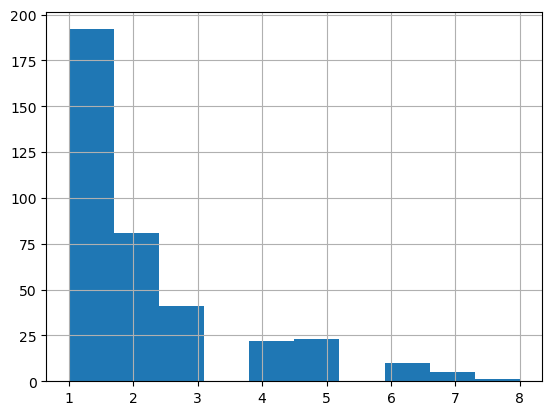

In [24]:
df_feats_list.query("(novel>0)|(answer)")["feature"].value_counts().hist()

In [25]:
df_feats_list.query("(novel>0)|(answer)")["feature"].nunique()

375

In [26]:
frequent_cases_list = ['(MEL) melanoma genetic risk', 'Microalbumin in urine',
       'IOP intraocular pressure genetic risk', 'Arm fat percentage',
       'EOC epithelial ovarian cancer genetic risk',
       '(AAM) age at menopause genetic risk']

df_freq_cases = df_feats_list.loc[(df_feats_list["raw_name"].isin(frequent_cases_list)) | (df_feats_list["feature"].isin(frequent_cases_list))][['raw_name',"feature",
                                                                                                                                                 'novel_cot', 'plausible_cot', 'novel', 'plausible',
       'utility', 'shortest_path_length', 'corr',  'p_val',
       'feature_importance', 'MutualInfoTarget', 'target', 'step_by_step_explanation', 'answer',
       'numeric_score']].sort_values("raw_name")

print(df_freq_cases["raw_name"].nunique())
df_freq_cases

8


,raw_name,feature,novel_cot,plausible_cot,novel,plausible,utility,shortest_path_length,corr,p_val,feature_importance,MutualInfoTarget,target,step_by_step_explanation,answer,numeric_score
40,(AAM) age at menopause genetic risk,(AAM) age at menopause genetic risk,The relationship between age at menopause (AAM...,The question asks whether there is a plausible...,1,0,0,99,-0.005,0.004,0.007,0.000,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,The feature '(AAM) age at menopause genetic ri...,True,3
32,(AAM) age at menopause genetic risk,(AAM) age at menopause genetic risk,The question asks whether the association betw...,The relationship between age at menarche (AAM)...,1,0,0,99,0.002,0.960,0.008,0.001,oesophagus cancer,The feature 'age at menopause (AAM) genetic ri...,True,3
13,(AAM) age at menopause genetic risk,(AAM) age at menopause genetic risk,The association between age at menopause and c...,Celiac disease is known to be associated with ...,1,1,0,99,-0.026,0.000,0.004,0.000,(celiac AND disease) OR (Coeliac) OR (gluten A...,The feature '(AAM) age at menopause genetic ri...,True,4
105,(AAM) age at menopause genetic risk,(AAM) age at menopause genetic risk,The association between age at menarche (AAM) ...,To determine if there is a plausible explanati...,1,0,0,99,0.002,0.744,0.007,0.000,Gout,1. **Novelty:** The association between age at...,False,2
34,(AAM) age at menopause genetic risk,(AAM) age at menopause genetic risk,The association between age at menopause (AAM)...,The relationship between age at menopause (AAM...,1,0,0,99,-0.004,0.027,0.006,0.001,(disc displacement) OR (disc degeneration) OR ...,1. **Novelty:** The association between age at...,True,4
6,(AAM) age at menopause genetic risk,(AAM) age at menopause genetic risk,The question pertains to the association betwe...,The relationship between age at menopause (AAM...,1,1,0,3,0.009,0.173,0.009,0.001,(Retinal Vein Occlusion) OR (Central retinal a...,The feature '(AAM) age at menopause genetic ri...,True,4
4,(AAM) age at menopause genetic risk,(AAM) age at menopause genetic risk,The association between age at menarche (AAM) ...,The relationship between age at menarche (AAM)...,1,1,0,99,0.004,0.169,0.026,0.001,Heart attack,The feature '(AAM) age at menopause genetic ri...,True,4
109,(EOC) epithelial ovarian cancer genetic risk,EOC epithelial ovarian cancer genetic risk,The question asks about the association betwee...,Epithelial ovarian cancer (EOC) is primarily i...,1,0,0,2,0.003,0.180,0.006,0.000,Gout,The feature 'EOC epithelial ovarian cancer gen...,False,2
93,(EOC) epithelial ovarian cancer genetic risk,EOC epithelial ovarian cancer genetic risk,The association between 'EOC epithelial ovaria...,Epithelial ovarian cancer (EOC) is primarily a...,1,0,0,3,0.002,0.668,0.007,0.000,(Retinal Vein Occlusion) OR (Central retinal a...,The feature 'EOC epithelial ovarian cancer gen...,False,2
87,(EOC) epithelial ovarian cancer genetic risk,EOC epithelial ovarian cancer genetic risk,The relationship between epithelial ovarian ca...,To determine if there is a plausible explanati...,1,0,0,2,-0.004,0.048,0.005,0.002,(Cholelithiasis) OR (Gallstone) OR (Gallbladde...,The feature 'EOC epithelial ovarian cancer gen...,False,2


In [27]:
df_freq_cases.drop_duplicates(["raw_name","answer"]).sort_values("raw_name").set_index(["raw_name"]).select_dtypes("number").round(3)
# df_freq_cases.set_index(["raw_name"]).select_dtypes("number").drop_duplicates()

,novel,plausible,utility,shortest_path_length,corr,p_val,feature_importance,MutualInfoTarget,numeric_score
raw_name,,,,,,,,,
(AAM) age at menopause genetic risk,1,0,0,99,-0.005,0.004,0.007,0.000,3
(AAM) age at menopause genetic risk,1,0,0,99,0.002,0.744,0.007,0.000,2
(EOC) epithelial ovarian cancer genetic risk,1,0,0,2,0.003,0.180,0.006,0.000,2
(EOC) epithelial ovarian cancer genetic risk,1,0,0,2,0.001,0.771,0.010,0.000,3
(IOP) intraocular pressure genetic risk,1,0,0,2,-0.008,0.108,0.005,0.000,2
(IOP) intraocular pressure genetic risk,1,0,0,2,0.001,0.949,0.006,0.000,3
(MEL) melanoma genetic risk,1,0,0,3,-0.005,0.625,0.004,0.000,2
(MEL) melanoma genetic risk,1,0,0,2,-0.020,0.000,0.007,0.000,3
Arm fat percentage (left),1,0,0,2,0.001,0.666,0.023,0.004,2
